In [1]:
%pwd

u'/mnt/data/fireModel'

In [2]:
%matplotlib inline

from __future__ import division,print_function

import os, sys, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import random

import matplotlib.image as mpimg
from PIL import Image, ImageEnhance
import pandas as pd

import cv2

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
current_dir = os.getcwd()

DATA_HOME_DIR = current_dir 

In [4]:
import utils; reload(utils)
from utils import plots

In [5]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/'
test_path = path + 'test/' #We use all the test data
#test_path = path +'MBTiles_TN/'
results_path=path + 'results/'
train_path=path + 'train/'
valid_path=path + 'valid/'

test_path

'/mnt/data/fireModel/test/'

In [7]:
from subprocess import check_output
print(check_output(["ls", test_path + "unknown"]).decode("utf8"))

File.10.png
File.11.png
File.12.png
File.13.png
File.14.png
File.15.png
File.16.png
File.17.png
File.18.png
File.19.png
File.1.png
File.20.png
File.21.png
File.22.png
File.23.png
File.24.png
File.25.png
File.26.png
File.27.png
File.28.png
File.29.png
File.2.png
File.30.png
File.31.png
File.32.png
File.33.png
File.34.png
File.35.png
File.36.png
File.37.png
File.38.png
File.39.png
File.3.png
File.40.png
File.41.png
File.42.png
File.43.png
File.44.png
File.45.png
File.46.png
File.47.png
File.48.png
File.49.png
File.4.png
File.50.png
File.51.png
File.52.png
File.53.png
File.54.png
File.55.png
File.56.png
File.57.png
File.58.png
File.59.png
File.5.png
File.60.png
File.61.png
File.62.png
File.63.png
File.64.png
File.65.png
File.66.png
File.67.png
File.68.png
File.69.png
File.6.png
File.70.png
File.71.png
File.72.png
File.73.png
File.74.png
File.75.png
File.76.png
File.77.png
File.7.png
File.8.png
File.9.png



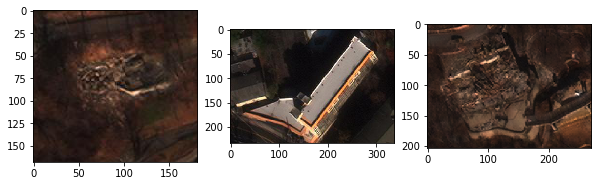

In [8]:
b2 = Image.open(train_path + 'Burned/Burned.15_out.jpg')
i2 = Image.open(train_path + 'Intact/Intact.15_out.jpg')
t2 = Image.open(test_path + 'unknown/File.9.png')
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(b2)
plt.subplot(132)
plt.imshow(i2)
plt.subplot(133)
plt.imshow(t2)
#plt.subplot(223)
#plt.imshow(b2)
#plt.subplot(224)
#plt.imshow(i2)

In [13]:
#import Vgg16 helper class
vgg = Vgg16()

In [14]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=3

In [15]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)

Found 215 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [16]:
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

In [17]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d"% epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
215/215 [==============================] - 15s - loss: 4.5664 - acc: 0.5581 - val_loss: 6.0659 - val_acc: 0.5778
Running epoch: 1
Epoch 1/1
215/215 [==============================] - 15s - loss: 2.1879 - acc: 0.8140 - val_loss: 0.4440 - val_acc: 0.9333
Running epoch: 2
Epoch 1/1
215/215 [==============================] - 15s - loss: 1.5540 - acc: 0.8186 - val_loss: 0.3592 - val_acc: 0.9778
Completed 3 fit operations


In [18]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 77 images belonging to 1 classes.


In [19]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the burned/intact directories.
#intact is 1 and burned is 0
print(preds[:5])

[[  1.0000e+00   6.1140e-17]
 [  3.0651e-11   1.0000e+00]
 [  4.3525e-15   1.0000e+00]
 [  1.1105e-28   1.0000e+00]
 [  1.7940e-16   1.0000e+00]]


In [20]:
filenames = batches.filenames
print(filenames[:5])

['unknown/File.19.png', 'unknown/File.37.png', 'unknown/File.45.png', 'unknown/File.60.png', 'unknown/File.32.png']


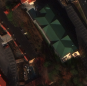

In [21]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path  + filenames[3])

In [22]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [23]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [24]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [25]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 45 images belonging to 2 classes.


In [26]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [27]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 44 correct labels


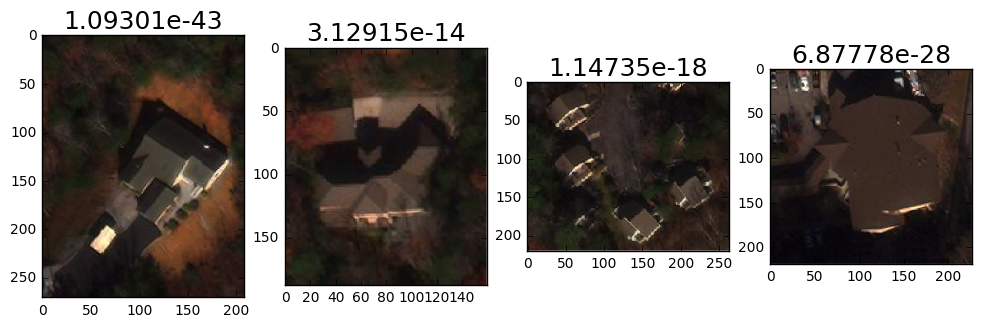

In [28]:

correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 1 incorrect labels


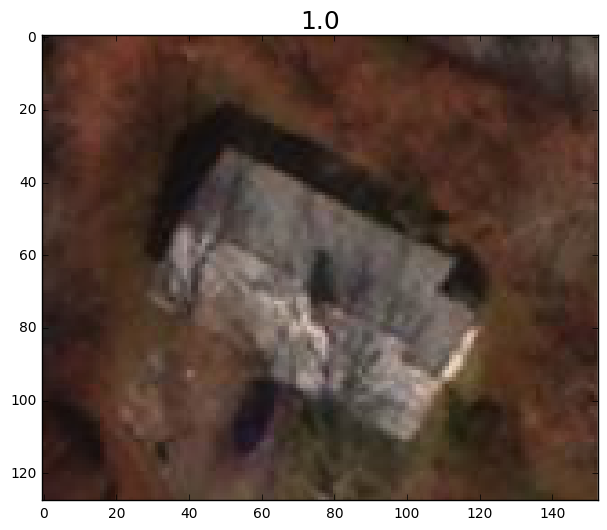

In [29]:

incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 25 confident correct burned building labels


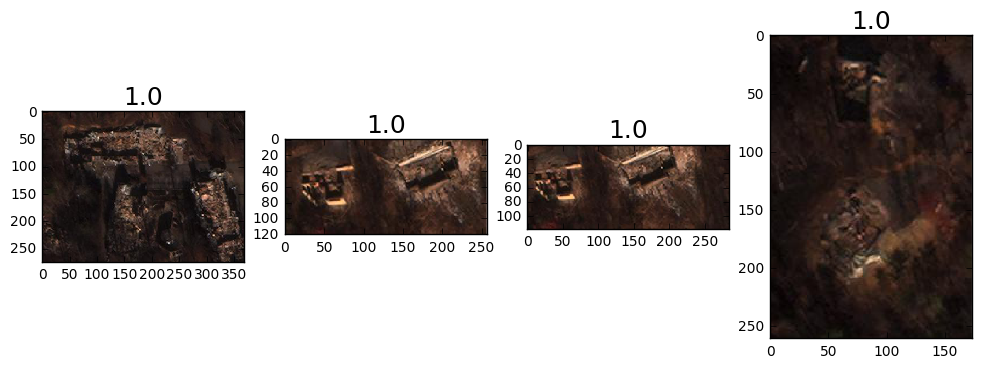

In [30]:

correct_burned = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct burned building labels" % len(correct_burned))
most_correct_burned = np.argsort(our_predictions[correct_burned])[::-1][:n_view]
plots_idx(correct_burned[most_correct_burned], our_predictions[correct_burned][most_correct_burned])

Found 19 confident correct intact buildings labels


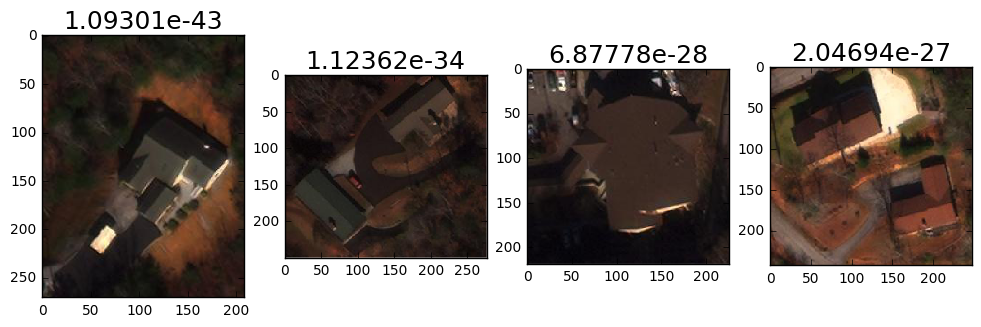

In [31]:
# The images we most confident were intact buildings, and are actually intact buildings
correct_intact = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct intact buildings labels" % len(correct_intact))
most_correct_intact = np.argsort(our_predictions[correct_intact])[:n_view]
plots_idx(correct_intact[most_correct_intact], our_predictions[correct_intact][most_correct_intact])

Found 1 incorrect burned building


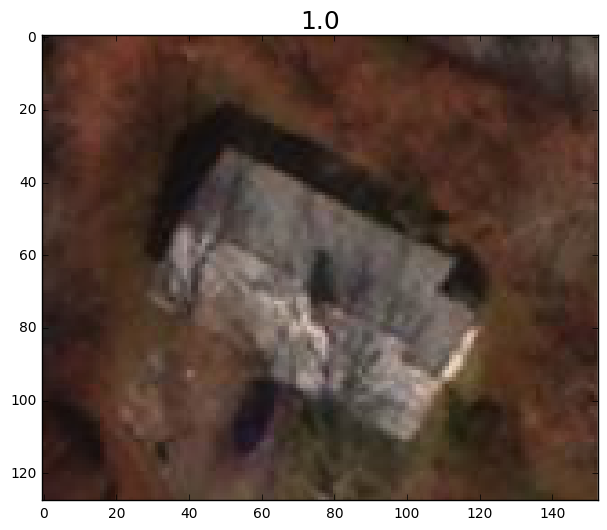

In [32]:
# The images we were most confident were burned buildings, but are actually intact buildings
incorrect_burned = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect burned building" % len(incorrect_burned))
if len(incorrect_burned):
    most_incorrect_burned = np.argsort(our_predictions[incorrect_burned])[::-1][:n_view]
    plots_idx(incorrect_burned[most_incorrect_burned], our_predictions[incorrect_burned][most_incorrect_burned])

In [33]:
# The images we were most confident were intact buildings, but are actually burned buildings
incorrect_intact = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect intact buildings" % len(incorrect_intact))
if len(incorrect_intact):
    most_incorrect_intact = np.argsort(our_predictions[incorrect_intact])[:n_view]
    plots_idx(incorrect_intact[most_incorrect_intact], our_predictions[incorrect_intact][most_incorrect_intact])

Found 0 incorrect intact buildings


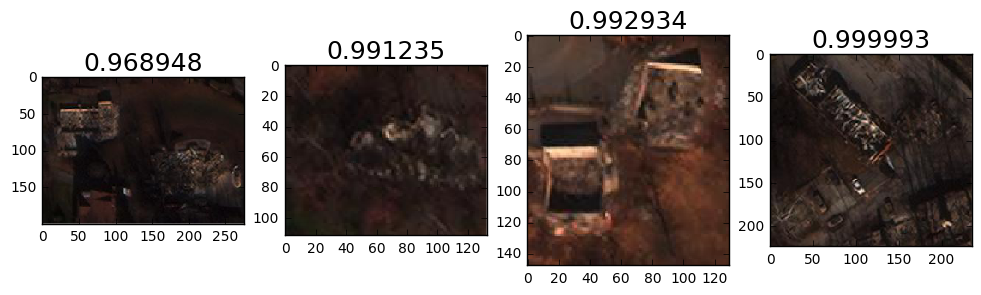

In [34]:
# The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

Confusion matrix, without normalization
[[25  0]
 [ 1 19]]


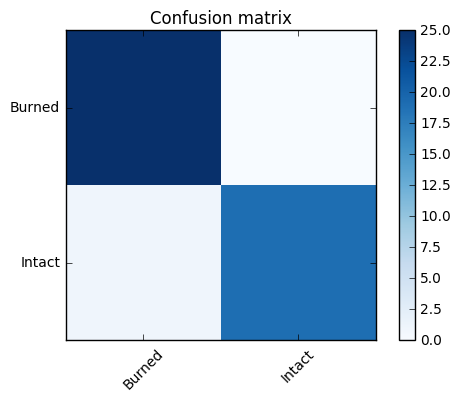

In [37]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [38]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [39]:
#Grab the intact buildings' prediction column
is_intact = preds[:,1]
print("Raw Predictions: " + str(is_intact[:5]))
print("Mid Predictions: " + str(is_intact[(is_intact < .6) & (is_intact > .4)]))
print("Edge Predictions: " + str(is_intact[(is_intact == 1) | (is_intact == 0)]))

Raw Predictions: [  6.1140e-17   1.0000e+00   1.0000e+00   1.0000e+00   1.0000e+00]
Mid Predictions: []
Edge Predictions: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.]


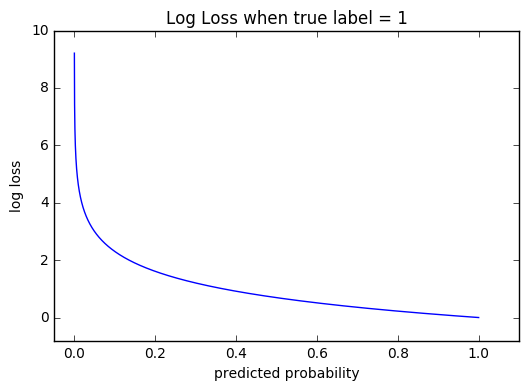

In [40]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()